In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import tensorflow
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras.callbacks import EarlyStopping

scaler = MinMaxScaler()

In [2]:
df = pd.read_csv("../Data/train_preprocessed.csv", low_memory=False)

features = ["Num_of_Loan", "Num_of_Delayed_Payment", "Interest_Rate", 'Annual_Income']
X = df[features].to_numpy()

y = df["Credit_Score"].to_numpy()
le = LabelEncoder()
le.fit(y)

y_norm = le.transform(y)

In [54]:
num = df.drop(columns=['Credit_Score']).select_dtypes(include=['number']).columns
cat = df.drop(columns=['Credit_Score', 'Customer_ID']).select_dtypes(include=['object']).columns

# Feature Selection with:
1. Mutual Information 
2. PCA
3. Gini (non quella di H.P.)
4. Random Forest (information Gain)

In [55]:
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif

#mutual_info_classif(df, y_norm)
MI_num = mutual_info_regression(df[num], y_norm)
MI_num_scores = pd.Series(dict(zip(num, MI_num))).sort_values(ascending=False)

In [56]:
MI_cat = mutual_info_classif(df[cat].apply(LabelEncoder().fit_transform), y_norm)
MI_cat_scores = pd.Series(dict(zip(cat, MI_cat))).sort_values(ascending=False)

In [57]:
MI_num_scores,  MI_cat_scores

(Outstanding_Debt            0.524132
 Monthly_Inhand_Salary       0.504840
 Total_EMI_per_month         0.471704
 Interest_Rate               0.180159
 Delay_from_due_date         0.123089
 Changed_Credit_Limit        0.118699
 Num_Credit_Inquiries        0.116184
 Num_Credit_Card             0.108838
 Credit_History_Age          0.105217
 Num_Bank_Accounts           0.099165
 Num_of_Delayed_Payment      0.088460
 Num_of_Loan                 0.073841
 Annual_Income               0.051417
 Monthly_Balance             0.030336
 Age                         0.021721
 Amount_invested_monthly     0.010677
 Credit_Utilization_Ratio    0.001324
 dtype: float64,
 Type_of_Loan             0.311855
 Credit_Mix               0.156430
 Payment_of_Min_Amount    0.110456
 Payment_Behaviour        0.006027
 Occupation               0.002327
 Month                    0.000206
 dtype: float64)

# Building the Model Datasets

In [4]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from imblearn.pipeline import Pipeline 
from imblearn.over_sampling import RandomOverSampler


cat_preprocessor = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                            ("onehot", OneHotEncoder(sparse=True, handle_unknown="ignore"))])

num_preprocessor = Pipeline([
                            ("imputer", SimpleImputer(strategy="median"))])

preprocessor = ColumnTransformer([
    ("numerical", num_preprocessor, num),
    ("categorical", cat_preprocessor, cat)
])

## Transforming
X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)

NameError: name 'num' is not defined

In [69]:
features_cat = list(MI_cat_scores[MI_cat_scores > 0.14].index)
features_num = list(MI_num_scores[MI_num_scores > 0.14].index)

X_cat = df[features_cat].apply(LabelEncoder().fit_transform).to_numpy()
X_num = df[features_num].to_numpy()
X_num = scaler.fit_transform(X_num)

X = np.column_stack([X_cat, X_num])

In [70]:
le = LabelEncoder()
le.fit(y)

y_norm = le.transform(y)

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y_norm, test_size=0.2)

In [72]:
n_input = X.shape[-1]
n_output = np.unique(y_norm).size

In [73]:
Arch = [
    Dense(units=n_input, activation='relu'),
    Dense(units=n_output, activation='linear')
]

model = Sequential(Arch)

In [74]:
opt = Adam(learning_rate=0.01)

model.compile(loss=SparseCategoricalCrossentropy(from_logits=True), optimizer=opt)

In [75]:
history = model.fit(X_train, y_train, epochs=100, validation_split=0.2)

Epoch 1/100
924/924 [==============================] - 1s 1ms/step - loss: 17.7101 - val_loss: 3.2290
Epoch 2/100
924/924 [==============================] - 1s 850us/step - loss: 3.7502 - val_loss: 1.9407
Epoch 3/100
924/924 [==============================] - 1s 853us/step - loss: 2.3350 - val_loss: 2.6378
Epoch 4/100
924/924 [==============================] - 1s 821us/step - loss: 1.5564 - val_loss: 0.9286
Epoch 5/100
924/924 [==============================] - 1s 837us/step - loss: 1.3582 - val_loss: 0.9237
Epoch 6/100
924/924 [==============================] - 1s 835us/step - loss: 1.0700 - val_loss: 1.2844
Epoch 7/100
924/924 [==============================] - 1s 836us/step - loss: 0.9811 - val_loss: 0.8965
Epoch 8/100
924/924 [==============================] - 1s 814us/step - loss: 0.9483 - val_loss: 0.9082
Epoch 9/100
924/924 [==============================] - 1s 821us/step - loss: 0.9722 - val_loss: 0.9831
Epoch 10/100
924/924 [==============================] - 1s 835us/step - lo

In [76]:
logits = model(X_train)
f_X = tensorflow.nn.softmax(logits)

In [77]:
y_hat = np.argmax(f_X, axis=1)

In [78]:
np.unique(np.argmax(f_X, axis=1), return_counts=1)

(array([0, 1, 2], dtype=int64), array([   58,    12, 36868], dtype=int64))

In [79]:
from sklearn.metrics import classification_report, confusion_matrix

In [80]:
print(classification_report(y_train, y_hat))

              precision    recall  f1-score   support

           0       0.60      0.01      0.01      6279
           1       0.33      0.00      0.00     11185
           2       0.53      1.00      0.69     19474

    accuracy                           0.53     36938
   macro avg       0.49      0.34      0.23     36938
weighted avg       0.48      0.53      0.37     36938



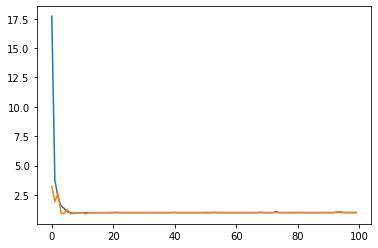

In [81]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
#plt.xlim(20,100)